In [1]:
from confirm.outlaw.nb_util import setup_nb

setup_nb()
import jax
import jax.numpy as jnp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import confirm.mini_imprint as ip

In [2]:
@jax.jit
def _sim(samples, theta, null_truth):
    return jnp.where(
        null_truth[:, None, 0],
        # negate so that we can do a less than comparison
        -(theta[:, None, 0] + samples[None, :]),
        jnp.inf,
    )


class ZTest1D:
    def __init__(self, seed, max_K, *, sim_batch_size=2048):
        self.family = "normal"
        self.sim_batch_size = sim_batch_size
        self.dtype = jnp.float32

        # sample normals and then compute the CDF to transform into the
        # interval [0, 1]
        key = jax.random.PRNGKey(seed)
        self.samples = jax.random.normal(key, shape=(max_K,), dtype=self.dtype)
        self._sim_batch = ip.batch(
            _sim, self.sim_batch_size, in_axes=(0, None, None), out_axes=(1,)
        )

    def sim_batch(self, begin_sim, end_sim, theta, null_truth, detailed=False):
        return self._sim_batch(self.samples[begin_sim:end_sim], theta, null_truth)

## Validation

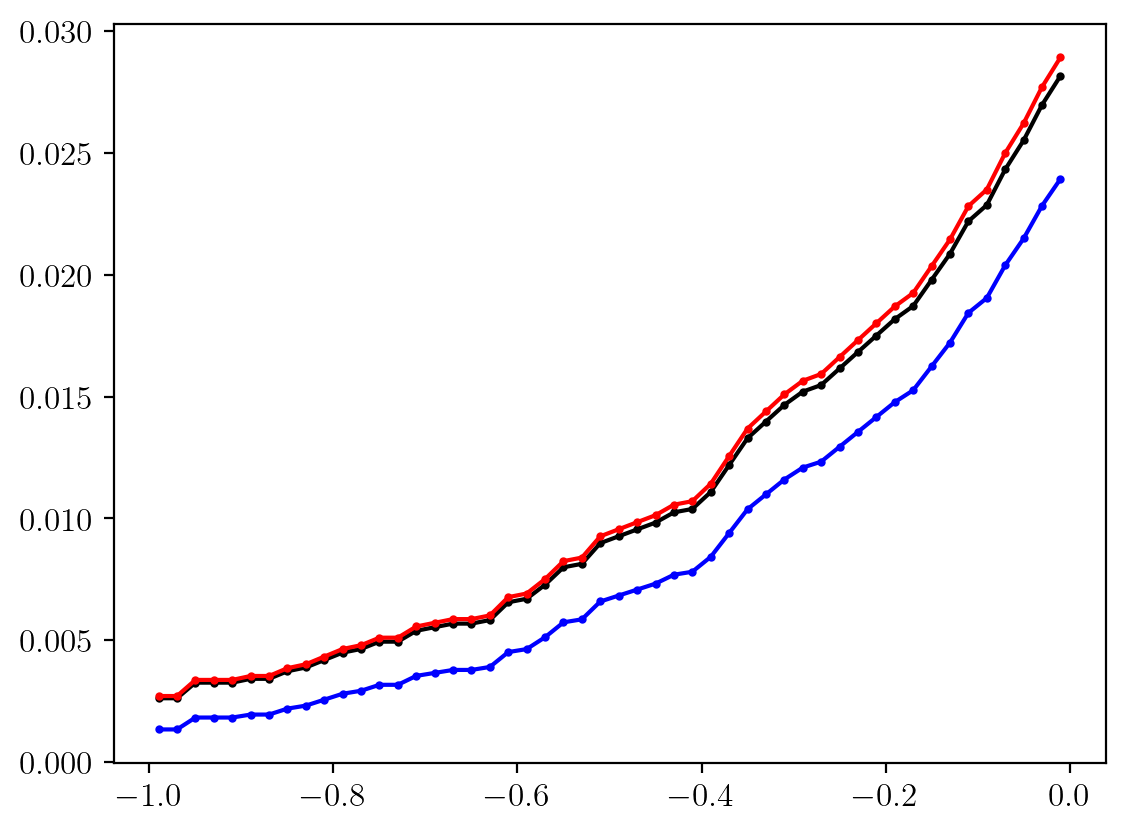

In [3]:
g = ip.cartesian_grid([-1], [1], n=[100], null_hypos=[ip.hypo("x < 0")])
# lam = -1.96 because we negated the statistics so we can do a less thanj
# comparison.
rej_df = ip.validate(ZTest1D, g, -1.96, K=8192)

plt.plot(g.df["theta0"], rej_df["TI_sum"] / rej_df["K"], "b-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_cp_bound"], "k-o", markersize=2)
plt.plot(g.df["theta0"], rej_df["TI_bound"], "r-o", markersize=2)
plt.show()

## Tuning

lambda**:  -2.00885986328125


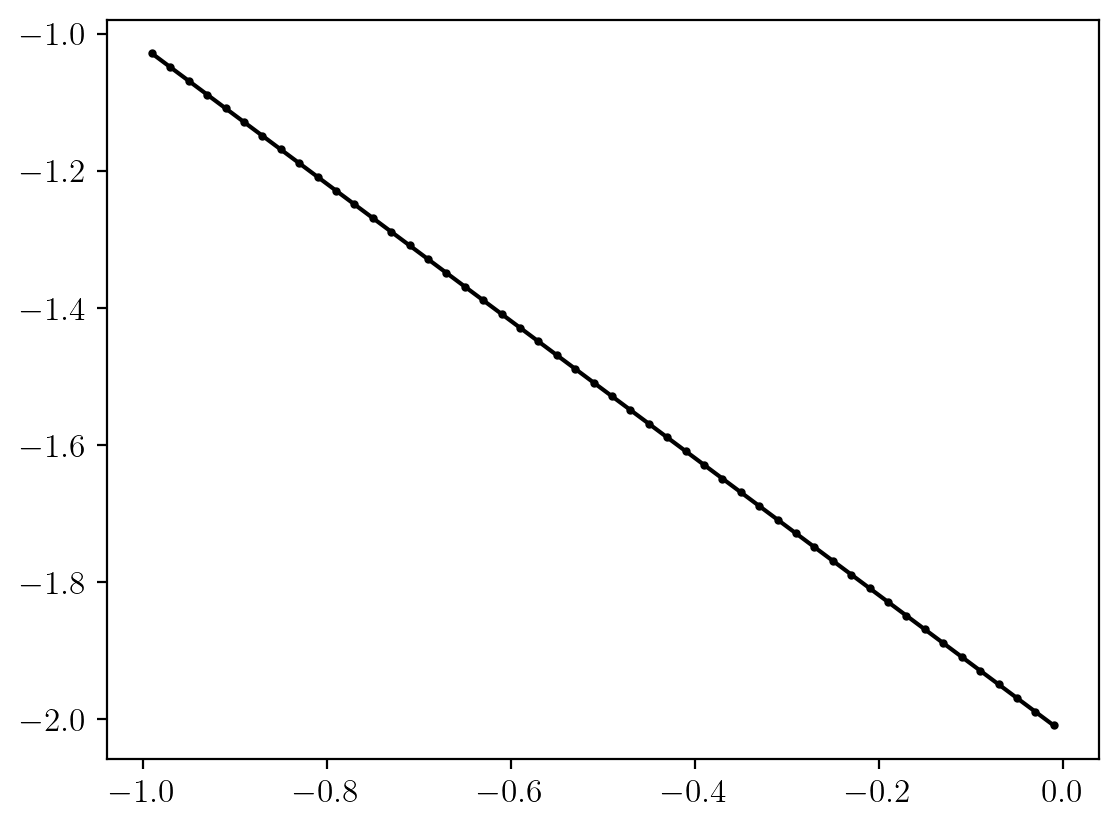

In [4]:
tune_df = ip.tune(ZTest1D, g)
print("lambda**: ", tune_df["lams"].min())
plt.plot(g.df["theta0"], tune_df["lams"], "k-o", markersize=2)
plt.show()

## Adagrid Tuning

In [5]:
g = ip.cartesian_grid(theta_min=[-1], theta_max=[1], null_hypos=[ip.hypo("x0 < 0")])
ada, reports = ip.ada_tune(ZTest1D, g, nB=5)

{
    'i': 1,
    'bias_tie': '0.000049',
    'std_tie': '0.000313',
    'spread_tie': '0.000977',
    'grid_cost': '0.019327',
    'n_refine': 1,
    'n_deepen': 0,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.985793',
    'B_lamss_min': '-2.014259',
    'B_lamss_max': '-1.915074',
    'tie_{k}(lamss)': '0.005493'
}

{
    'i': 2,
    'bias_tie': '0.000024',
    'std_tie': '0.000760',
    'spread_tie': '0.002441',
    'grid_cost': '0.012713',
    'n_refine': 1,
    'n_deepen': 1,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.954579',
    'B_lamss_min': '-1.974801',
    'B_lamss_max': '-1.923409',
    'tie_{k}(lamss)': '0.012085'
}

{
    'i': 3,
    'bias_tie': '-0.000122',
    'std_tie': '0.001417',
    'spread_tie': '0.004639',
    'grid_cost': '0.007336',
    'n_refine': 1,
    'n_deepen': 2,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.963464',
    'B_lamss_min': '-2.002300',
    'B_lamss_max': '-1.918043',
    'tie_{k}(lamss)': '0.017456'
}

{
    'i': 4,
    'bias_tie': '-0.000098',
    'std_tie': '0.001640',
    'spread_tie': '0.005371',
    'grid_cost': '0.003945',
    'n_refine': 1,
    'n_deepen': 3,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.959059',
    'B_lamss_min': '-2.015432',
    'B_lamss_max': '-1.911305',
    'tie_{k}(lamss)': '0.020874'
}

{
    'i': 5,
    'bias_tie': '0.000146',
    'std_tie': '0.001613',
    'spread_tie': '0.005493',
    'grid_cost': '0.002046',
    'n_refine': 1,
    'n_deepen': 4,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.944948',
    'B_lamss_min': '-2.027439',
    'B_lamss_max': '-1.907838',
    'tie_{k}(lamss)': '0.022827'
}

{
    'i': 6,
    'bias_tie': '0.000220',
    'std_tie': '0.001792',
    'spread_tie': '0.006104',
    'grid_cost': '0.001042',
    'n_refine': 2,
    'n_deepen': 4,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.949910',
    'B_lamss_min': '-2.018049',
    'B_lamss_max': '-1.893726',
    'tie_{k}(lamss)': '0.023804'
}

{
    'i': 7,
    'bias_tie': '0.000513',
    'std_tie': '0.001496',
    'spread_tie': '0.004883',
    'grid_cost': '0.000526',
    'n_refine': 3,
    'n_deepen': 5,
    'n_finished': 0,
    'n_impossible': 0,
    'lamss': '-1.952397',
    'B_lamss_min': '-2.012593',
    'B_lamss_max': '-1.918901',
    'tie_{k}(lamss)': '0.024292'
}

In [6]:
import scipy.stats

g = ip.Grid(ada.tiledb.get_all())
ga = g.subset(g.df["active"])
lamss = ga.df["lams"].min()
true_err = 1 - scipy.stats.norm.cdf(-lamss)
lamss, true_err

(-1.9537866115570068, 0.02536322914037914)

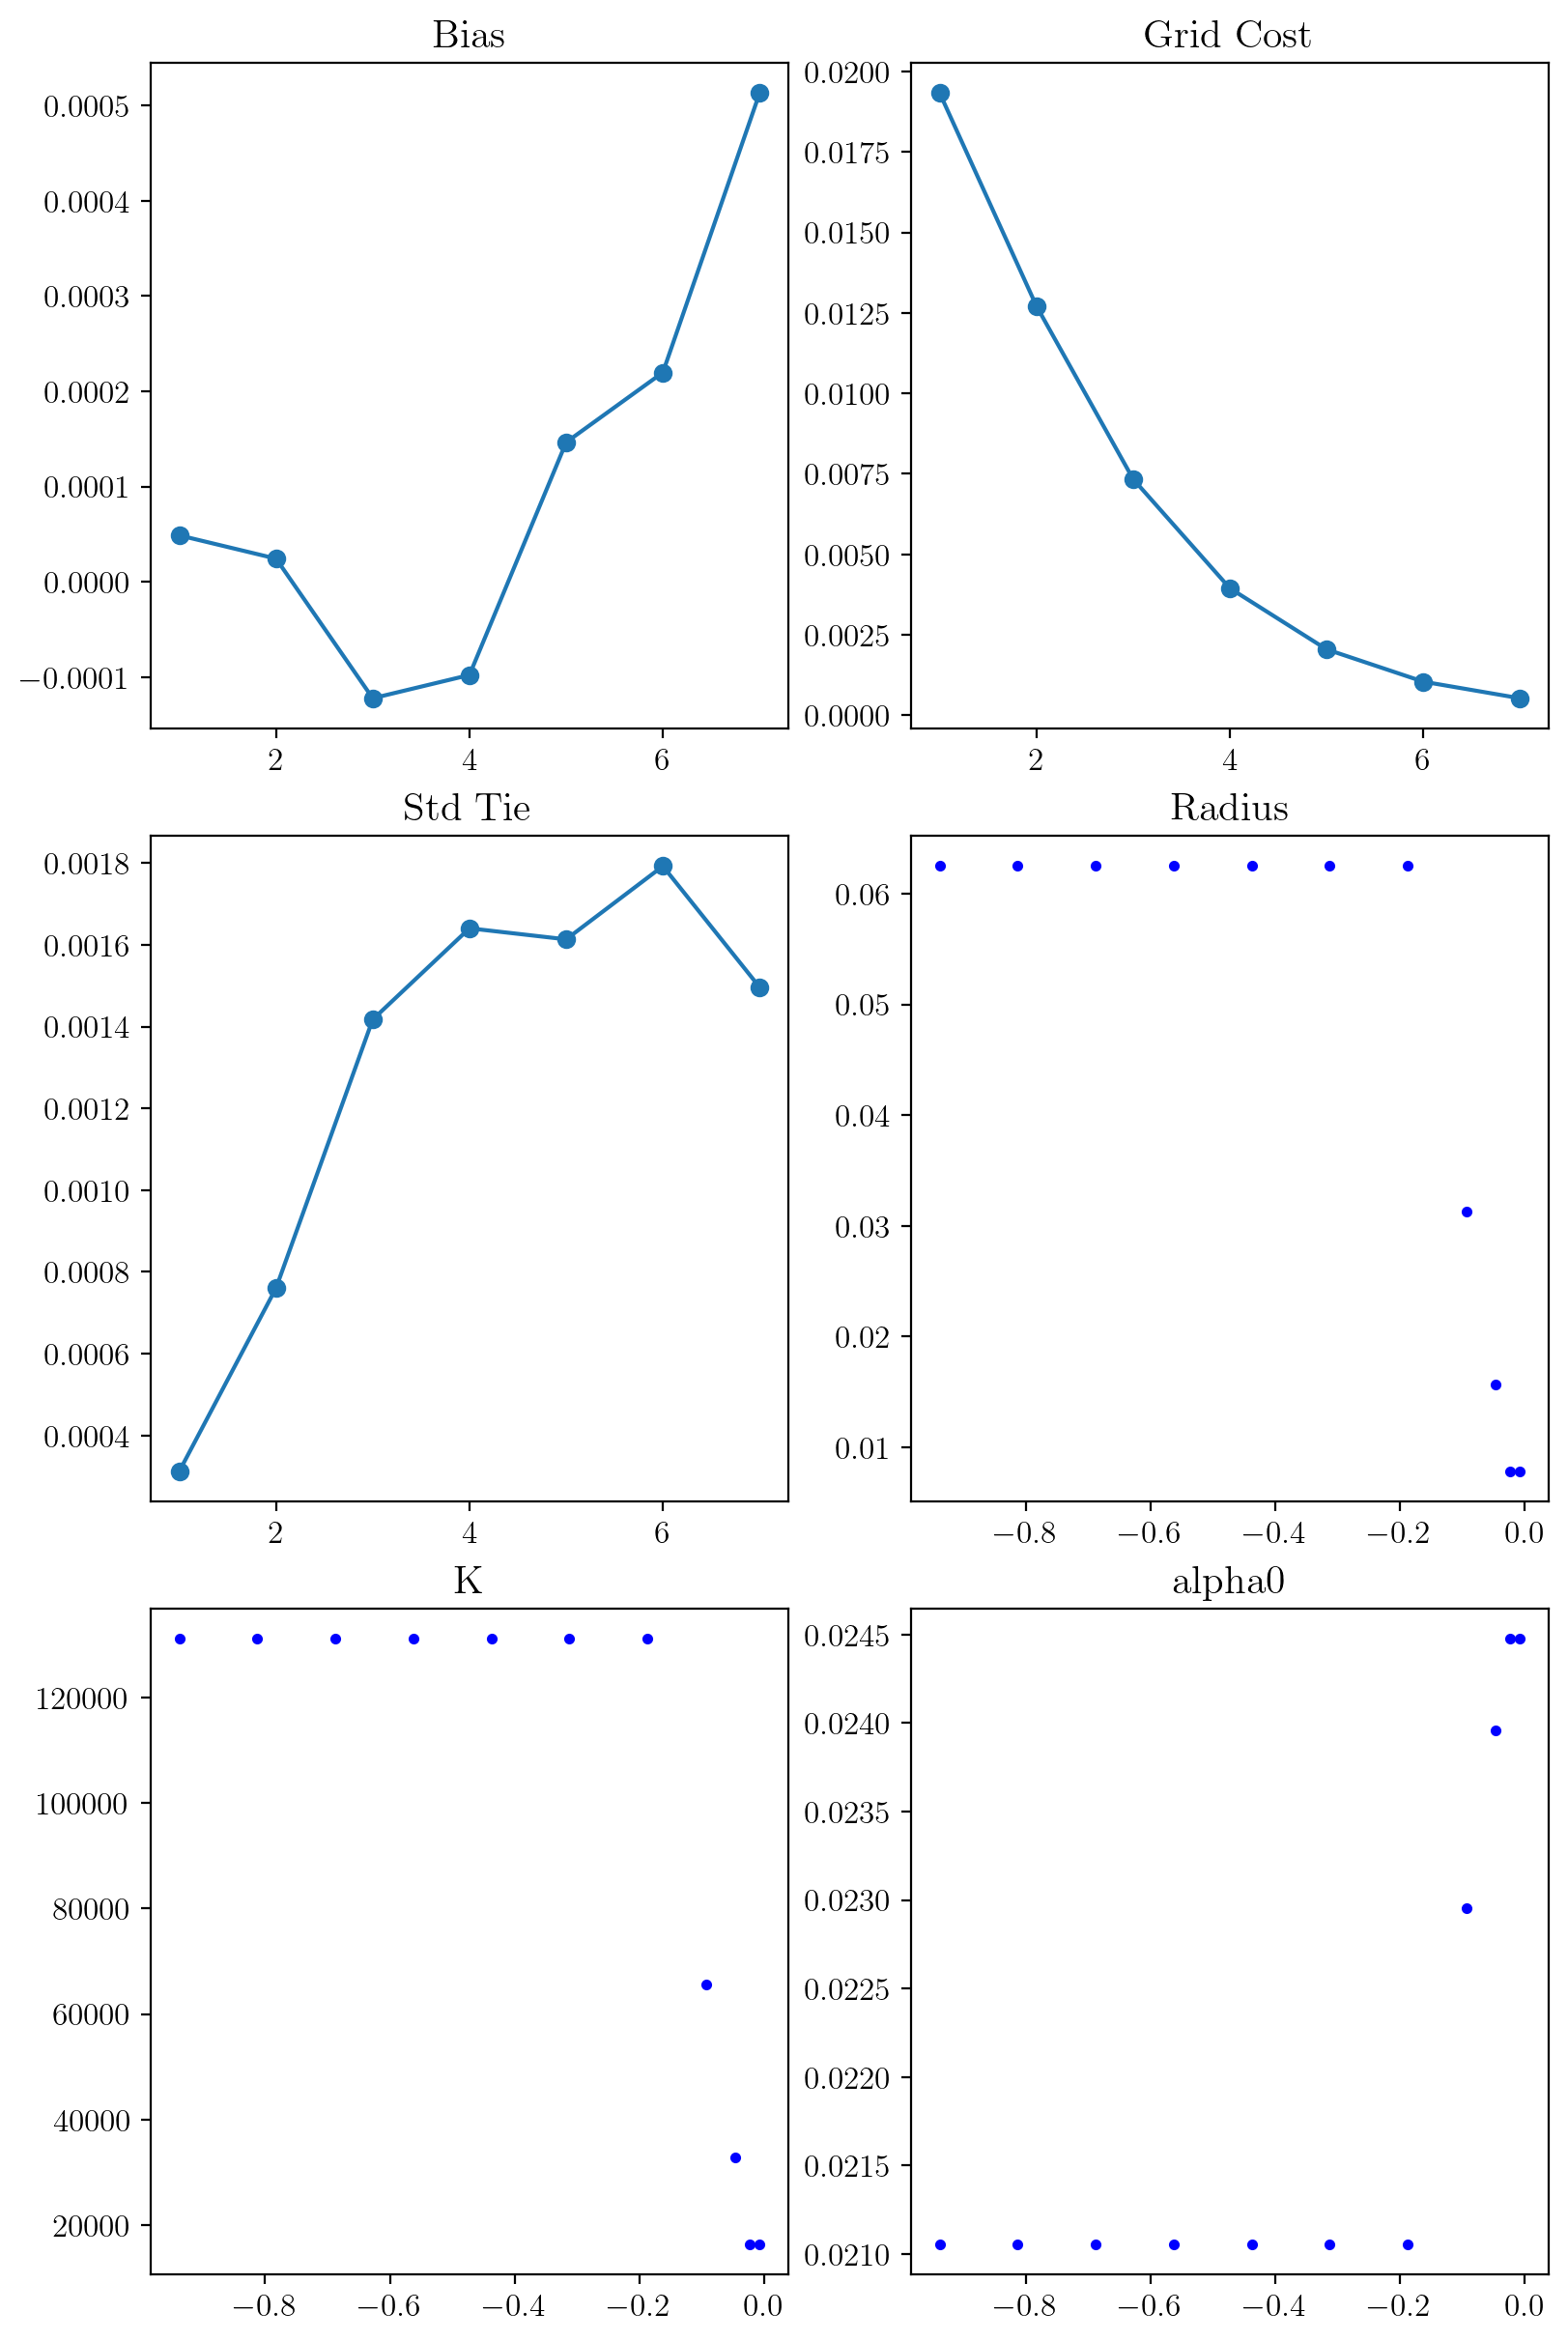

In [7]:
evolution = pd.DataFrame(reports)
# Figure plotting bias, grid_cost and std_tie
fig, ax = plt.subplots(3, 2, figsize=(8, 12), constrained_layout=True)
ax[0][0].plot(evolution["i"], evolution["bias_tie"], "o-")
ax[0][0].set_title("Bias")
ax[0][1].plot(evolution["i"], evolution["grid_cost"], "o-")
ax[0][1].set_title("Grid Cost")
ax[1][0].plot(evolution["i"], evolution["std_tie"], "o-")
ax[1][0].set_title("Std Tie")
ax[1][1].plot(ga.get_theta()[:, 0], ga.get_radii()[:, 0], "bo", markersize=3)
ax[1][1].set_title("Radius")
ax[2][0].plot(ga.get_theta()[:, 0], ga.df["K"], "bo", markersize=3)
ax[2][0].set_title("K")
ax[2][1].plot(ga.get_theta()[:, 0], ga.df["alpha0"], "bo", markersize=3)
ax[2][1].set_title("alpha0")
plt.show()